In [1]:
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /home/nv/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/nv/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
from nltk.corpus import treebank
tagged_sentences = treebank.tagged_sents(tagset='universal')

In [3]:
print(tagged_sentences[0])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


In [4]:
train = tagged_sentences[:3000]
test = tagged_sentences[3000:]

In [5]:
tagset = set([tag for sent in tagged_sentences for token,tag in sent])

In [6]:
tag2ids = {tag:id for id,tag in enumerate(tagset)}
tag2ids

{'.': 0,
 'PRON': 1,
 'NOUN': 2,
 'DET': 3,
 'ADV': 4,
 'ADJ': 5,
 'VERB': 6,
 'X': 7,
 'NUM': 8,
 'CONJ': 9,
 'ADP': 10,
 'PRT': 11}

In [7]:
import collections
word_counter = collections.Counter([token.lower() for sent in train for token,tag in sent])

In [8]:
vocab = [k for k,v in word_counter.items() if v > 3]
vocab[:10]

[',',
 'years',
 'old',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive']

In [9]:
word2ids = {}
word2ids = {token:id+2 for id,token in enumerate(vocab)}
word2ids['<UNK>'] = 0
word2ids['<PAD>'] = 1

In [10]:
list(word2ids.items())[:10]

[(',', 2),
 ('years', 3),
 ('old', 4),
 ('will', 5),
 ('join', 6),
 ('the', 7),
 ('board', 8),
 ('as', 9),
 ('a', 10),
 ('nonexecutive', 11)]

In [11]:
import numpy as np

def preprocessing(data):
    labels = [tag2ids[tag] for sent in data for token,tag in sent]
    str_data = [['<PAD>' if i==0 else sent[i-1][0],sent[i][0],'<PAD>' if i==len(sent)-1 else sent[i+1][0]] for sent in data for i in range(len(sent))]
    out_data = [[word2ids[token] if token in word2ids else word2ids['<UNK>'] for token in item ] for item in str_data]
    return np.asarray(out_data),np.asarray(labels)

In [12]:
train_data,train_labels = preprocessing(train)
test_data,test_labels = preprocessing(test)

In [13]:
print(train_data[:10])

[[1 0 0]
 [0 0 2]
 [0 2 0]
 [2 0 3]
 [0 3 4]
 [3 4 2]
 [4 2 5]
 [2 5 6]
 [5 6 7]
 [6 7 8]]


In [14]:
print(train_labels[:10])

[2 2 0 8 2 5 0 6 6 3]


In [15]:
from tensorflow.keras import models, layers, optimizers
import tensorflow.keras as keras

In [16]:
vocab_size = len(word2ids.keys())
tag_size = len(tag2ids.keys())
model = keras.Sequential()
model.add(layers.Embedding(vocab_size,100,input_shape=[3]))
model.add(layers.Dropout(0.5))
model.add(layers.SimpleRNN(200,dropout=0.2,recurrent_dropout=0.2))
model.add(keras.layers.Dense(tag_size,activation='softmax'))

model.summary()

In [17]:
model.compile(optimizer=optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
history=model.fit(train_data,train_labels,epochs=40,batch_size=1000,validation_split=0.1,verbose=2)

Train on 69759 samples, validate on 7752 samples
Epoch 1/40
69759/69759 - 4s - loss: 1.4841 - accuracy: 0.5648 - val_loss: 0.7335 - val_accuracy: 0.7797
Epoch 2/40
69759/69759 - 2s - loss: 0.6017 - accuracy: 0.8197 - val_loss: 0.4327 - val_accuracy: 0.8729
Epoch 3/40
69759/69759 - 2s - loss: 0.4366 - accuracy: 0.8728 - val_loss: 0.3545 - val_accuracy: 0.8922
Epoch 4/40
69759/69759 - 2s - loss: 0.3804 - accuracy: 0.8869 - val_loss: 0.3271 - val_accuracy: 0.8969
Epoch 5/40
69759/69759 - 2s - loss: 0.3492 - accuracy: 0.8947 - val_loss: 0.3138 - val_accuracy: 0.8998
Epoch 6/40
69759/69759 - 2s - loss: 0.3281 - accuracy: 0.9014 - val_loss: 0.3044 - val_accuracy: 0.9066
Epoch 7/40
69759/69759 - 2s - loss: 0.3156 - accuracy: 0.9047 - val_loss: 0.2996 - val_accuracy: 0.9071
Epoch 8/40
69759/69759 - 2s - loss: 0.3023 - accuracy: 0.9074 - val_loss: 0.2972 - val_accuracy: 0.9044
Epoch 9/40
69759/69759 - 2s - loss: 0.2938 - accuracy: 0.9102 - val_loss: 0.2925 - val_accuracy: 0.9066
Epoch 10/40
697

In [19]:
result = model.evaluate(test_data,test_labels)

23165/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [20]:
print(result)

[0.2949709960976533, 0.906022]


In [21]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.plot('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

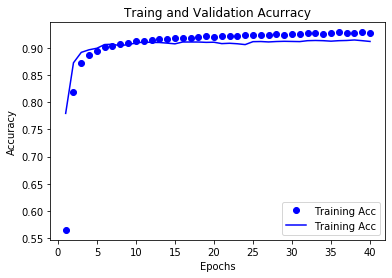

In [23]:
plt.clf()
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs,acc_values,'bo',label='Training Acc')
plt.plot(epochs,val_acc_values,'b',label='Training Acc')
plt.title('Traing and Validation Acurracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()